In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Music Genre Classification/genres_original'

**bold text**# Data Preprocessing

In [4]:
#define your folder structure
classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [5]:
from tensorflow.image import resize
#Load and preprocess audio data
def load_and_preprocess_data(data_dir,classes,target_shape=(150,150)):
    data=[]
    labels=[]

    for i_class,class_name in enumerate(classes):
        # Use os.path.join to create the full path to the class directory.
        class_dir = os.path.join(data_dir, class_name)
        print("Processing--",class_dir) # Print the full path to debug
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir,filename)
                audio_data,sample_rate = librosa.load(file_path,sr=None)
                #Performing Preprocessing
                #define the duration of each chunk and overlap
                chunk_duration = 4
                overlap_duration = 2

                #Convert duration to sample
                chunk_samples = chunk_duration * sample_rate
                overlap_samples = overlap_duration * sample_rate

                #Calculate the number of chunks
                num_chunks = int(np.ceil((len(audio_data)-chunk_samples)/(chunk_samples-overlap_samples)))+1

                #iterate over each chunks
                for i in range(num_chunks):
                    #Calculate start and end indices of the chunk
                    start = i*(chunk_samples-overlap_samples)
                    end = start+chunk_samples
                    #Extract the chunk audio
                    chunk = audio_data[start:end]
                    #Melspectrogram part
                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sample_rate)
                    #Resize matrix based on provided target shape
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram,axis=-1),target_shape)
                    #Append data to list
                    data.append(mel_spectrogram)
                    labels.append(i_class)
    #Return
    return np.array(data),np.array(labels)

In [6]:
data,labels = load_and_preprocess_data(data_dir,classes)

Processing-- /content/drive/MyDrive/Colab Notebooks/Music Genre Classification/genres_original/blues
Processing-- /content/drive/MyDrive/Colab Notebooks/Music Genre Classification/genres_original/classical
Processing-- /content/drive/MyDrive/Colab Notebooks/Music Genre Classification/genres_original/country
Processing-- /content/drive/MyDrive/Colab Notebooks/Music Genre Classification/genres_original/disco
Processing-- /content/drive/MyDrive/Colab Notebooks/Music Genre Classification/genres_original/hiphop
Processing-- /content/drive/MyDrive/Colab Notebooks/Music Genre Classification/genres_original/jazz
Processing-- /content/drive/MyDrive/Colab Notebooks/Music Genre Classification/genres_original/metal
Processing-- /content/drive/MyDrive/Colab Notebooks/Music Genre Classification/genres_original/pop
Processing-- /content/drive/MyDrive/Colab Notebooks/Music Genre Classification/genres_original/reggae
Processing-- /content/drive/MyDrive/Colab Notebooks/Music Genre Classification/genres_

In [7]:
data.shape

(14975, 150, 150, 1)

In [8]:
labels.shape

(14975,)

In [9]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels,num_classes = len(classes)) # Converting labels to one-hot encoding
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])



# Splitting of Dataset

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,test_size=0.2,random_state=42)

In [11]:
model = tf.keras.models.Sequential()

In [12]:
X_train[0].shape

(150, 150, 1)

In [13]:
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=X_train[0].shape))
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [15]:
model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [16]:
model.add(Dropout(0.3))

In [17]:
model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [18]:
model.add(Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [19]:
model.add(Dropout(0.3))

In [20]:
model.add(Flatten())

In [21]:
model.add(Dropout(0.45))

In [22]:
#Output layer
model.add(Dense(units=len(classes),activation='softmax'))

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 148, 148, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 74, 74, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,732,138 (18.05 MB)

 Trainable params: 4,732,138 (18.05 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
#Compile the model
# Import Adam directly from tensorflow.keras.optimizers
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
#Training Model
training_history = model.fit(X_train,Y_train,epochs=30,batch_size=32,validation_data=(X_test,Y_test))

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 64s 130ms/step - accuracy: 0.1809 - loss: 2.2037 - val_accuracy: 0.3669 - val_loss: 1.7765
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 50s 79ms/step - accuracy: 0.3969 - loss: 1.6972 - val_accuracy: 0.5259 - val_loss: 1.3654
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.5360 - loss: 1.3382 - val_accuracy: 0.6367 - val_loss: 1.0691
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.6362 - loss: 1.0744 - val_accuracy: 0.6855 - val_loss: 0.9557
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.6753 - loss: 0.9381 - val_accuracy: 0.6942 - val_loss: 0.8924
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.7228 - loss: 0.8207 - val_accuracy: 0.7526 - val_loss: 0.7552
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.7600 - loss: 0.7301 - val_accuracy: 0.7766 - val_loss: 0.7123
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.7938 - loss: 0.6161 -

In [26]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/Colab Notebooks/Music Genre Classification/saved models/Trained_model.h5')

In [28]:
model.save('/content/drive/MyDrive/Colab Notebooks/Music Genre Classification/saved models/Trained.keras')


In [31]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Music Genre Classification/saved models/Trained_model.h5')

In [32]:
training_history.history

{'accuracy': [0.23747913539409637,
  0.4389816224575043,
  0.5570951700210571,
  0.6385642886161804,
  0.6843071579933167,
  0.7279632687568665,
  0.7689482569694519,
  0.7959933280944824,
  0.8188647627830505,
  0.8405675888061523,
  0.8675292134284973,
  0.8746243715286255,
  0.8942403793334961,
  0.9026710987091064,
  0.9132721424102783,
  0.9194490909576416,
  0.9325542449951172,
  0.936978280544281,
  0.9373121857643127,
  0.9497495889663696,
  0.9513355493545532,
  0.9585976600646973,
  0.9580968022346497,
  0.9608514308929443,
  0.9627712965011597,
  0.96652752161026,
  0.9697829484939575,
  0.970450758934021,
  0.9714524149894714,
  0.9747913479804993],
 'loss': [2.062655448913574,
  1.5994852781295776,
  1.2772386074066162,
  1.0668649673461914,
  0.9269343614578247,
  0.8075013756752014,
  0.7051525712013245,
  0.6155419945716858,
  0.5425844788551331,
  0.4790286123752594,
  0.39906051754951477,
  0.38348817825317383,
  0.32742077112197876,
  0.2956542372703552,
  0.26502218

In [ ]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

In [33]:
X_train

array([[[[2.16342449e+00],
         [1.01336346e+01],
         [1.44714069e+01],
         ...,
         [8.10373425e-01],
         [4.94901717e-01],
         [9.85581040e-01]],

        [[2.08488865e+01],
         [8.26843109e+01],
         [7.97624969e+01],
         ...,
         [2.12929573e+01],
         [8.74905777e+00],
         [1.07430935e+01]],

        [[5.15504608e+01],
         [1.11120438e+02],
         [8.40804062e+01],
         ...,
         [8.87450180e+01],
         [2.84056721e+01],
         [2.38014126e+01]],

        ...,

        [[1.55806309e-03],
         [3.19159386e-04],
         [1.54418331e-06],
         ...,
         [4.50833249e-06],
         [3.89431407e-05],
         [4.14071430e-04]],

        [[1.54487253e-03],
         [3.14586359e-04],
         [8.00902882e-08],
         ...,
         [3.09359734e-07],
         [3.36363519e-05],
         [4.14549344e-04]],

        [[1.54148787e-03],
         [3.13779630e-04],
         [1.00114672e-08],
         ...,
 

In [35]:
#Reloading model variable
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Music Genre Classification/saved models/Trained_model.h5')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 148, 148, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 74, 74, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,732,140 (18.05 MB)

 Trainable params: 4,732,138 (18.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [40]:
#Recording History in json
import json
# Make sure the path is correct and the file is saved in this location
file_path = '/content/drive/MyDrive/Colab Notebooks/Music Genre Classification/saved models/training_hist.json'
with open(file_path, 'w') as f:
  json.dump(training_history.history, f)

# ... (other code) ...

#Reloading Training history
import json
# Use the same path here when loading
with open(file_path, 'r') as json_file:
    training_history_data = json.load(json_file)

In [41]:
training_history_data.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

# Model Evaluation - I

In [42]:
#Model evaluation on Training set
train_loss,train_accuracy = model.evaluate(X_train,Y_train)

375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9949 - loss: 0.0181


In [43]:
train_loss,train_accuracy

(0.01845363900065422, 0.9953255653381348)

In [44]:
#Model evaluation on Validation set
val_loss,val_accuracy = model.evaluate(X_test,Y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9098 - loss: 0.4069


In [45]:
val_loss,val_accuracy

(0.3818768262863159, 0.9128547310829163)

In [46]:
training_history_data['val_loss']

[1.7765065431594849,
 1.365373134613037,
 1.0690630674362183,
 0.9557346701622009,
 0.8923909068107605,
 0.7552258968353271,
 0.7122796773910522,
 0.5900972485542297,
 0.7362906336784363,
 0.5410022139549255,
 0.6133965253829956,
 0.5120929479598999,
 0.5422831177711487,
 0.42677009105682373,
 0.42588111758232117,
 0.4920903742313385,
 0.45022690296173096,
 0.4012496769428253,
 0.5340575575828552,
 0.3605303168296814,
 0.33300313353538513,
 0.5533351302146912,
 0.39350560307502747,
 0.4341227412223816,
 0.3460250794887543,
 0.3361426293849945,
 0.43760624527931213,
 0.3423578143119812,
 0.38867661356925964,
 0.3818768262863159]

# Accuracy and Loss Visualization

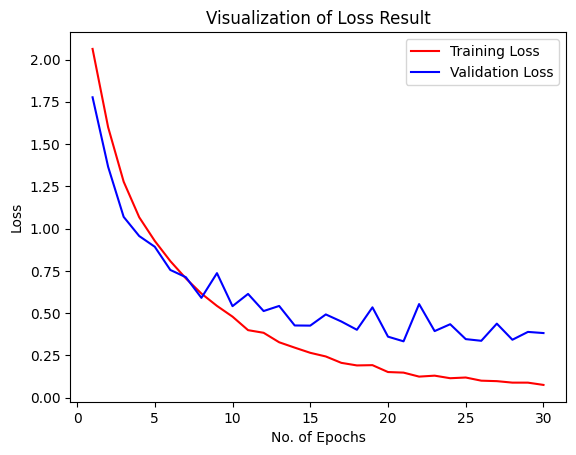

In [47]:
#Visualization of Loss
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history_data['loss'],label="Training Loss",color='red')
plt.plot(epochs,training_history_data['val_loss'],label="Validation Loss",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

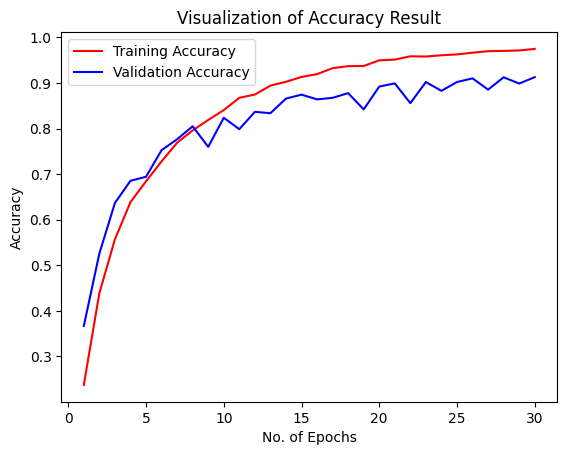

In [48]:
#Visualization of Accuracy
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history_data['accuracy'],label="Training Accuracy",color='red')
plt.plot(epochs,training_history_data['val_accuracy'],label="Validation Accuracy",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

# Precision,Recall,Confusion Matrix - Model Evaluation-II


In [49]:
X_test.shape

(2995, 150, 150, 1)

In [50]:
y_pred = model.predict(X_test)
y_pred

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


array([[1.6409029e-23, 2.3396493e-25, 4.9198839e-22, ..., 1.0000000e+00,
        8.0720961e-15, 1.3075953e-20],
       [8.2861392e-13, 7.1122513e-13, 9.5693080e-12, ..., 6.8709877e-12,
        1.3316370e-14, 6.5459908e-06],
       [5.1585036e-10, 8.6397228e-18, 9.9329766e-15, ..., 7.3268457e-18,
        4.6553685e-15, 1.5131828e-11],
       ...,
       [1.0000000e+00, 1.2063039e-30, 7.3892612e-13, ..., 2.5693152e-27,
        1.0554680e-25, 1.2437868e-19],
       [8.7188200e-06, 9.9980229e-01, 1.5855861e-06, ..., 2.4609981e-05,
        2.5552567e-06, 7.5857483e-06],
       [1.1753211e-14, 4.6694849e-17, 2.1908779e-21, ..., 1.1730283e-09,
        7.3126991e-11, 1.1730467e-12]], dtype=float32)

In [51]:
y_pred.shape

(2995, 10)

In [52]:
predicted_categories = np.argmax(y_pred,axis=1)
predicted_categories

array([7, 6, 6, ..., 0, 1, 4])

In [53]:
Y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [54]:
Y_test.shape

(2995, 10)

In [55]:
true_categories = np.argmax(Y_test,axis=1)
true_categories

array([7, 6, 6, ..., 0, 1, 4])

In [56]:
classes

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [57]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(true_categories,predicted_categories)
# Precision Recall F1score
print(classification_report(true_categories,predicted_categories,target_names=classes))


              precision    recall  f1-score   support

       blues       0.89      0.92      0.91       302
   classical       0.93      0.98      0.95       298
     country       0.90      0.81      0.85       317
       disco       0.96      0.91      0.93       312
      hiphop       0.95      0.94      0.94       277
        jazz       0.91      0.89      0.90       311
       metal       0.95      0.95      0.95       302
         pop       0.91      0.91      0.91       289
      reggae       0.98      0.91      0.94       296
        rock       0.78      0.91      0.84       291

    accuracy                           0.91      2995
   macro avg       0.92      0.91      0.91      2995
weighted avg       0.92      0.91      0.91      2995



# Confusion Matrix Visualization

In [58]:
cm

array([[279,   0,  10,   1,   0,   3,   0,   3,   0,   6],
       [  0, 292,   1,   0,   0,   4,   0,   1,   0,   0],
       [ 14,   2, 257,   0,   2,  12,   1,   3,   3,  23],
       [  2,   2,   4, 283,   2,   0,   3,   2,   0,  14],
       [  1,   0,   0,   2, 259,   1,   2,   7,   1,   4],
       [  7,  15,   2,   1,   0, 278,   0,   2,   0,   6],
       [  1,   0,   2,   0,   2,   0, 287,   0,   0,  10],
       [  2,   2,   4,   1,   4,   0,   0, 263,   2,  11],
       [  7,   1,   3,   3,   3,   4,   0,   3, 270,   2],
       [  0,   1,   4,   4,   0,   4,   8,   4,   0, 266]])

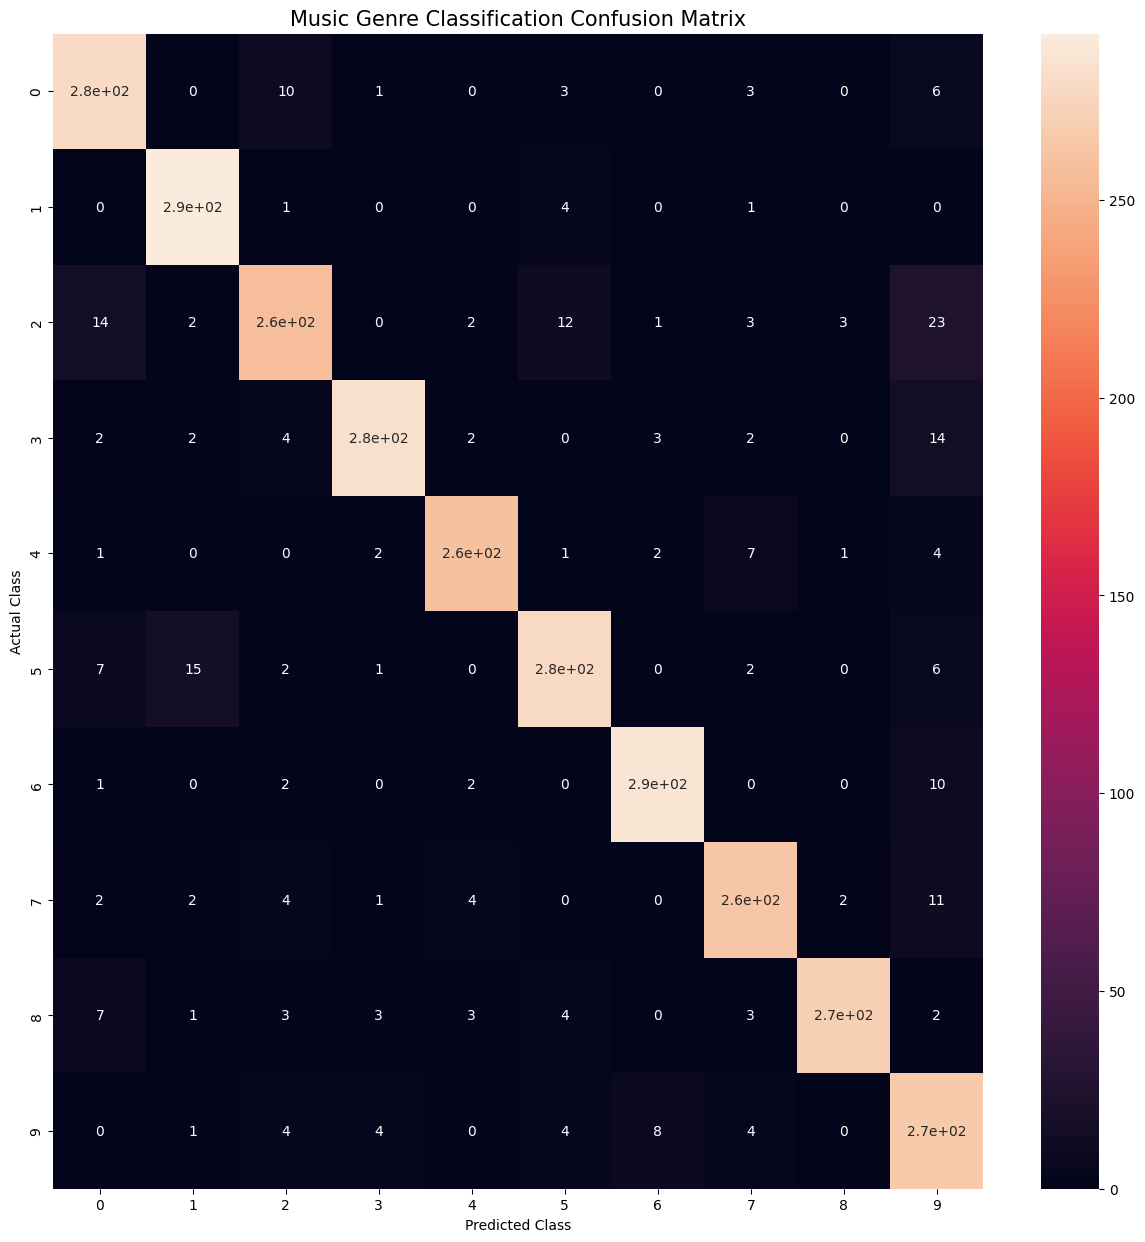

In [59]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(cm,annot=True,annot_kws={"size":10})
plt.xlabel("Predicted Class",fontsize=10)
plt.ylabel("Actual Class",fontsize=10)
plt.title("Music Genre Classification Confusion Matrix",fontsize=15)
plt.show()